In this kernel I'll be working on analyzing the text present in article headlines. I'll also be training a rudimentary model towards the end of the analysis that attempts to predict if an article headline contains sarcasm or not.

## Exploratory Data Analysis

The first thing I do when attempting to analyze any dataset is to load the `tidyverse` package. This package is a collection of incredibly helpful packages that all help in analyzing data through the *tidy* approach.

In [1]:
library(tidyverse) # metapackage with lots of helpful functions
list.files(path = "../input")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0.9000     ✔ purrr   0.3.0     
✔ tibble  2.0.1          ✔ dplyr   0.7.8     
✔ tidyr   0.8.2          ✔ stringr 1.3.1     
✔ readr   1.3.1          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


[1] "Sarcasm_Headlines_Dataset.json"

From the above section, we can see that the dataset is encoded in the `.json` format, which is different from the traditional `.csv`s I'm used to. To successfully parse the json data, I'll be using the following packages:
*     `rjson`
*      `jsonlite`

In [2]:
library(rjson)
library(jsonlite)


Attaching package: ‘jsonlite’

The following objects are masked from ‘package:rjson’:

    fromJSON, toJSON

The following object is masked from ‘package:purrr’:

    flatten



After reading the file, we need to convert it into a suitable format for our analysis; this is easily done using the `tbl_df()` function that converts our data into a `tibble` for efficient manipulation across the tidyverse.

I then use `glimpse()` and `head()` in order to briefly look at the data.

One could interpret the `article_link` column as a unique identifier in our dataset, but for easier manipulation and analysis I create a new unique variable for each row, `document`.

In [3]:
sarcasmDF <- file("../input/Sarcasm_Headlines_Dataset.json", open = "r") %>%
    stream_in() %>%
    tbl_df()
sarcasmDF %>% 
glimpse()

sarcasmDF %>% 
head()

sarcasmDF  <- sarcasmDF %>% 
mutate(document = row_number())

 Imported 26709 records. Simplifying...
Observations: 26,709
Variables: 3
$ article_link <chr> "https://www.huffingtonpost.com/entry/versace-black-code…
$ headline     <chr> "former versace store clerk sues over secret 'black code…
$ is_sarcastic <int> 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,…


article_link,headline,is_sarcastic
https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0
https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1
https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0
https://www.huffingtonpost.com/entry/advancing-the-worlds-women_b_6810038.html,advancing the world's women,0


The `tidytext` package is a core component of the `tidyverse`. As the name suggests, it helps in analyzing textual data whlie also following the principles of *tidy* data, unlike some popular text mining packages like `tm`.

The `unnest_tokens` function present in the package tokenizes the text by its individual words by default after pre-processing the text, after which I then use the `anti_join()` function on the `stop_words` dataset present within the package itself to remove commonly occurring words like articles, pronouns, etc.

I use `group_by()` and `top_n()` in order to list the top 20 most frequently occurring words present in both sarcastic and non-sarcastic article headlines.

Joining, by = "word"
Selecting by n


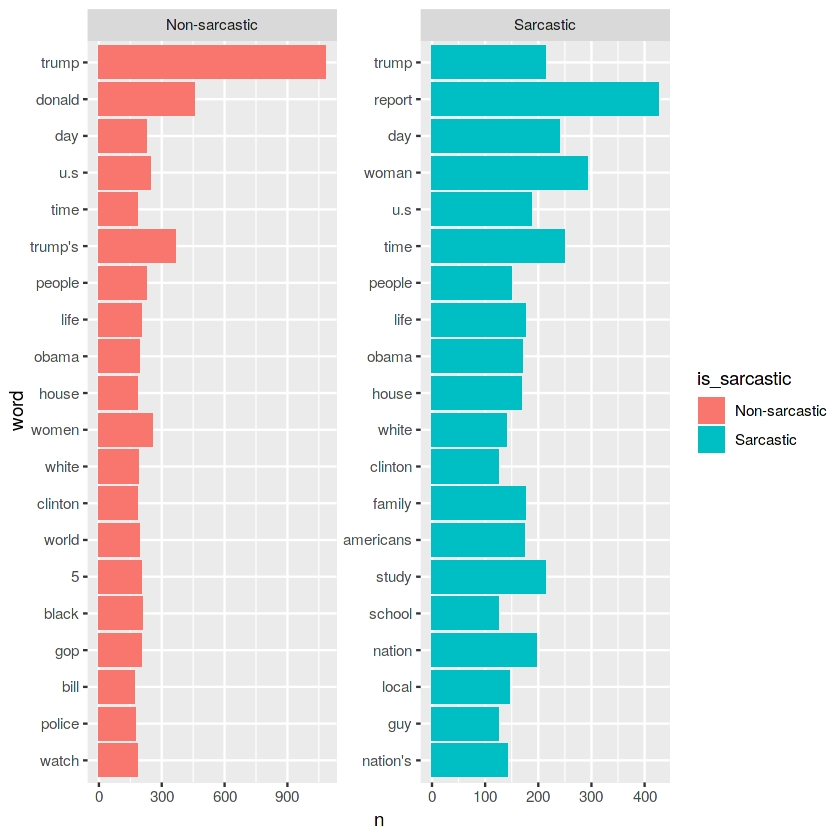

In [4]:
library(tidytext)

headlineText <- sarcasmDF %>% 
unnest_tokens(word, headline) %>% 
anti_join(stop_words)


headlineText %>% 
count(word, is_sarcastic, sort = TRUE) %>% 
mutate(is_sarcastic = factor(is_sarcastic, labels = c("Non-sarcastic", "Sarcastic")),
      word = as.factor(word),
      word = fct_reorder(word,n)
      ) %>% 
group_by(is_sarcastic) %>% 
top_n(20)  %>% 
ungroup() %>% 
ggplot(aes(word, n)) +
geom_col(aes(fill = is_sarcastic)) +
facet_wrap(~is_sarcastic, scales = "free") +
coord_flip()

The `tidytext` package also contains a `get_sentiments()` function that returns the sentiments associated with most words present in the English language; I use an `inner_join()` on the *bing* sentiment lexicon and the tokenized text we have to get sentiments associated for each word in our dataset.

After that, I plot the most frequent words split across the two sentiments present in the lexicon, positive and negative. I do this by using `group_by()` and `top_n()`.

I filter out the word *trump* because the headlines mostly feature it as a surname, whereas the lexicon contains it as a positive verb.

Joining, by = "word"
Selecting by n


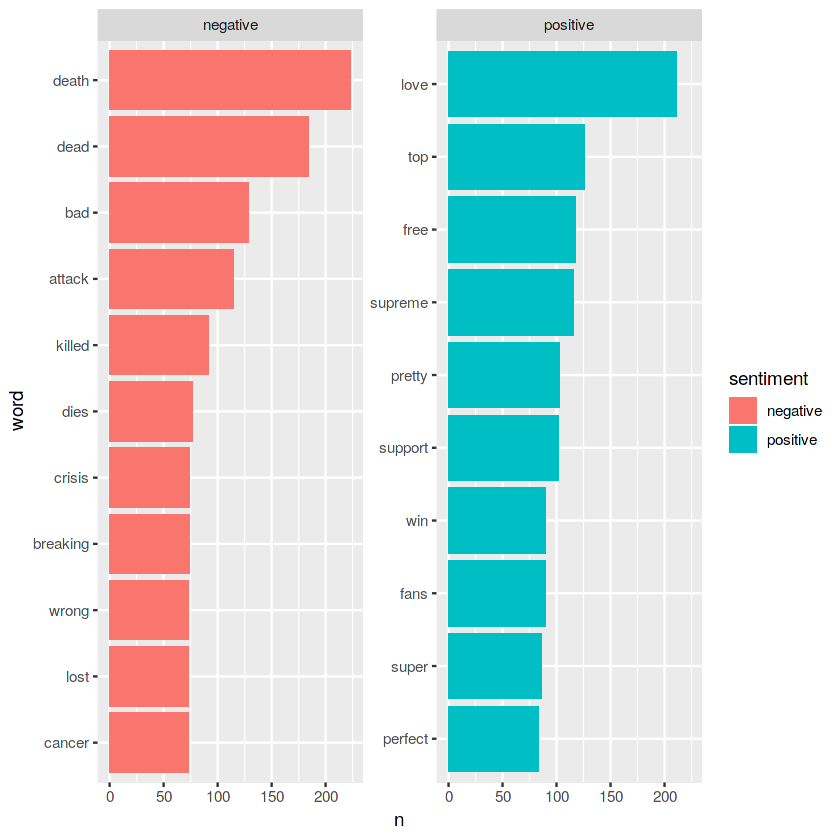

In [5]:
headlineText %>% 
inner_join(get_sentiments("bing")) %>% 
filter(word!="trump") %>% 
count(word, sentiment, sort = TRUE) %>% 
mutate(sentiment = as.factor(sentiment),
      word = as.factor(word),
      word = fct_reorder(word,n)) %>% 
group_by(sentiment) %>% 
top_n(10) %>% 
ungroup() %>% 
ggplot(aes(word, n)) +
geom_col(aes(fill = sentiment)) +
facet_wrap(~sentiment, scales = "free_y") +
coord_flip()


The *term frequency-inverse document frequency*, or *tf-idf* metric is used to measure how important a word is with respect to the document it is present in. It helps us get an idea of which words are more specific to which document, or in this case, which *class* of article headlines (sarcastic or non-sarcastic).

The `tidytext` package contains the `bind_tf_idf` function that calculates the tf-idf metric for each word present in the dataset with respect to the class of the article headline the word is a part of.

I first `arrange()` the dataset according to the tf_idf values of each word, after which I split the tokenized data with respect to the `is_sarcastic` column. I then use the `map()` function from the `purrr` package to get the top-10 most specific words (with respect to *tf-idf*), after which I use `ggplot` to plot the same graph for the two classes (sarcastic and non-sarcastic) by calling `ggplot` inside a `map()` call.

$`Non-sarcastic`

$Sarcastic


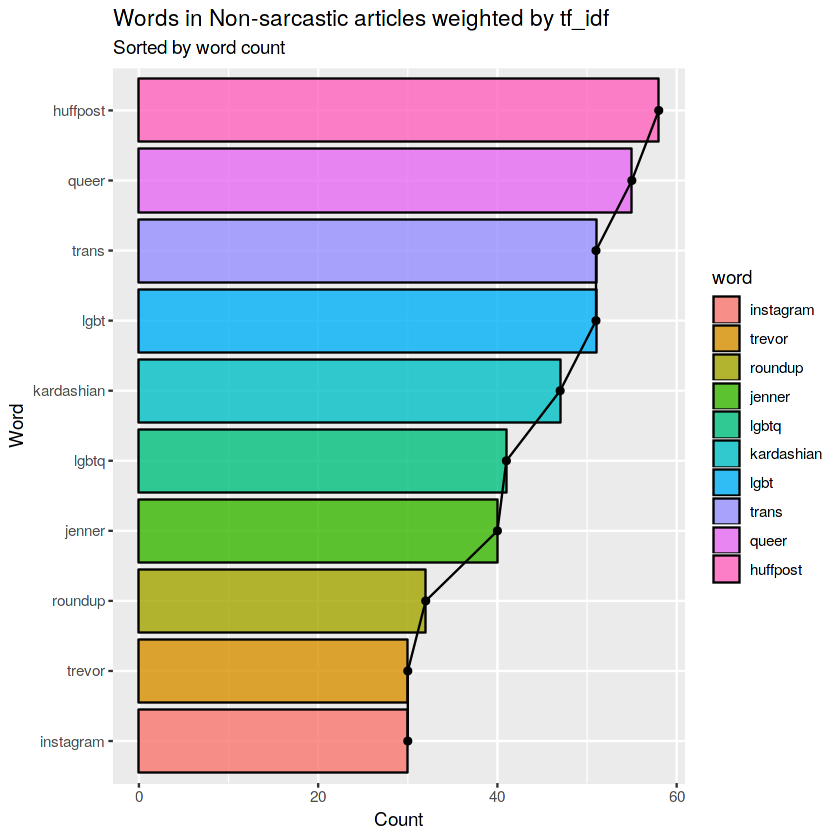

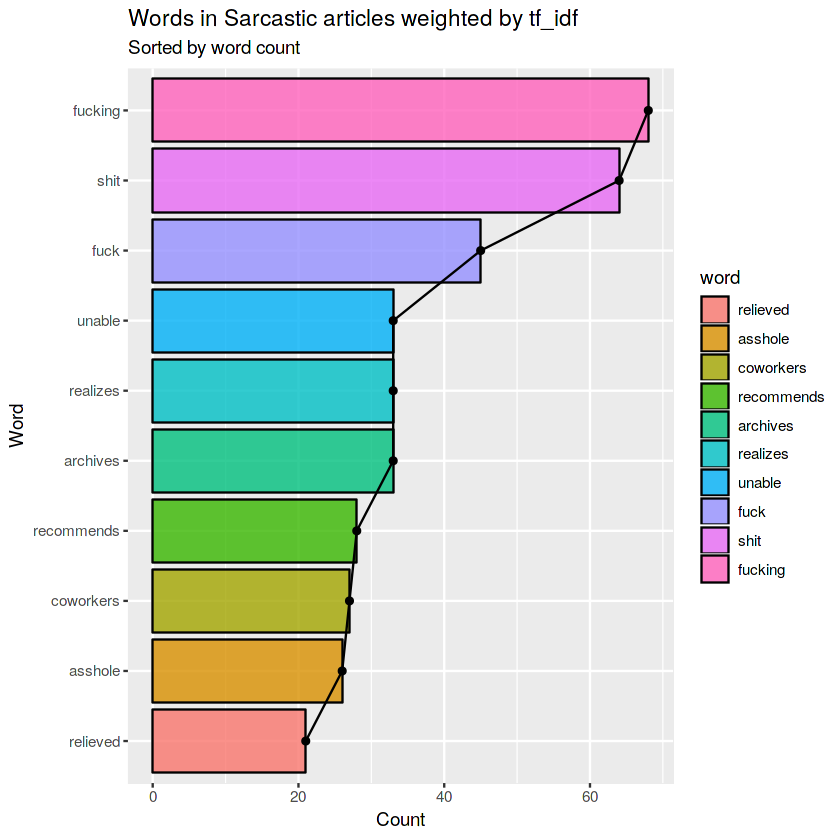

In [6]:
headlineText %>% 
mutate(is_sarcastic = factor(is_sarcastic, labels = c("Non-sarcastic", "Sarcastic"))) %>% 
count(word, is_sarcastic, sort = TRUE) %>% 
bind_tf_idf(is_sarcastic, word, n) %>% 
arrange(desc(tf_idf)) %>% 
mutate(word = as.factor(word),
      word = fct_reorder(word, n)) %>% 
split(.$is_sarcastic) %>% 
purrr::map(~head(10, x = .)) %>% 
purrr::map(~tbl_df(data = .)) %>% 
purrr::map(~ggplot(data = ., mapping = aes(word, n)) + 
           geom_col(aes(fill = word), alpha = 0.8, color = "black") +
           geom_line(group = 1) +
           geom_point() +
           coord_flip() +
           guides(alpha = FALSE) +
           labs(title = paste("Words in",.$is_sarcastic,"articles weighted by tf_idf"), x = "Word", y = "Count", subtitle = "Sorted by word count")
          )

Expletives are frequently present in sarcastic news headlines, according to our visualization.

So far, we've only looked at the dataset as a collection of individual *words*. However, the `unnest_tokens()` package also has a `token` argument, which lets us decide the unit according to which we wish to tokenize the text. By default, the function tokenizes according to each individual word, but we can also use `token = "ngrams"` in order to tokenize the text according to *n-grams*, or units of words that appear next to each other.

I use `n=2` to tokenize the text into *bigrams*, or pairs of words that occur together.

I filter the words to separate out commonly occurring words, after which I use the `igraph` and `ggraph` packages to visualize the words as a network. This is done using the `graph_from_data_frame()` function present in the `igraph` package that transforms the dataset into a set of nodes and edges, and the `ggraph()` function that converts the previously returned graph into a `ggraph` object that can be manipulated in a similar manner as regular `ggplot` objects.


Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Using `nicely` as default layout


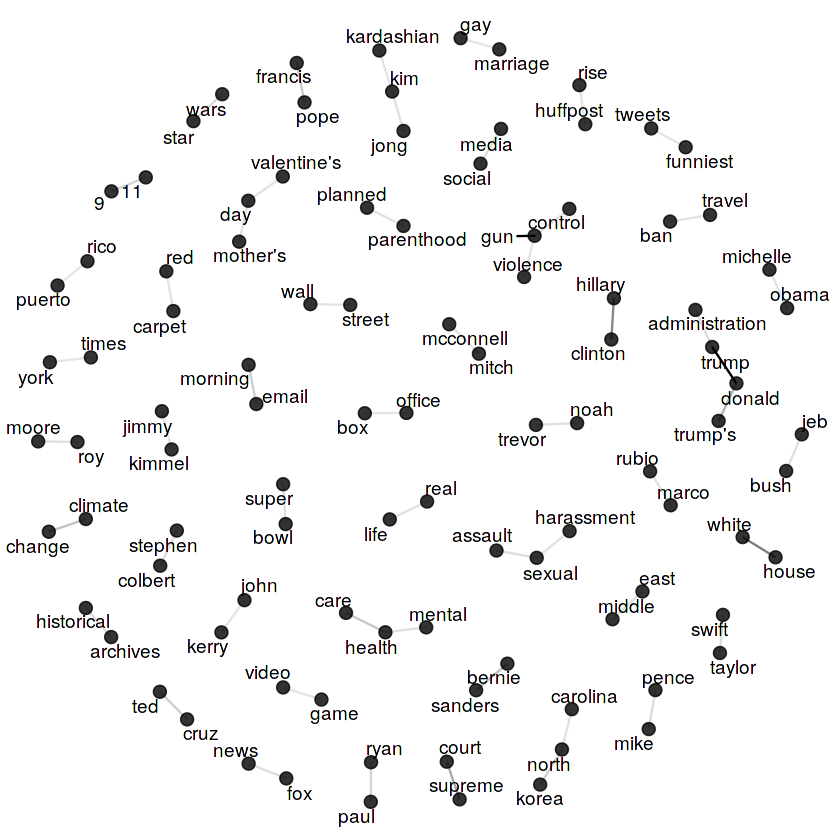

In [7]:
library(igraph)
library(ggraph)
library(ggrepel)

set.seed(100)

sarcasmBigrams <- sarcasmDF %>% 
unnest_tokens(bigrams, headline, token = "ngrams", n = 2) %>% 
separate(bigrams, sep = " ", into = c("word1", "word2")) %>% 
filter(!word1 %in% stop_words$word & !word2 %in% stop_words$word) %>% 
filter(word1!=" " | word2 != " ")
#unite(bigram, word1, word2, sep = " ") %>% 

sarcasmBigrams %>% 
count(word1, word2, sort = TRUE) %>% 
filter(n>20) %>% 
graph_from_data_frame() %>% 
ggraph() +
geom_edge_link(aes(edge_alpha = n)) +
geom_node_point(alpha = 0.8, size = 3) +
geom_node_text(aes(label = name), repel = TRUE) +
guides(alpha = FALSE, edge_alpha = FALSE) +
theme_void()


The previous graph visualized bigrams that are frequent in occurrence as well as successive in nature, but there may be times when words occur together in the same headline, but not necessarily next to each other. This can be done using the `pairwise_cors()` function present in the `widyr` package, that calculates the correlations for the words present in our dataset. Words that are highly correlated occur more frequently in the same article headline, even if they may not be near each other.

The following graph uses `ggraph()` and `graph_from_data_frame()` to visualize a network of words that are highly correlated with each other, instead of just occurring immediately after a particular word (as shown in the previous graph). I created a vector called `commonNames` in order to filter out commonly occurring names in the dataset.

The transparency of the edges in the graph reflects the correlation of the words present, as shown in the `geom_edge_link(aes(edge_alpha = correlation))` layer I add to the `ggraph` object.

Using `nicely` as default layout


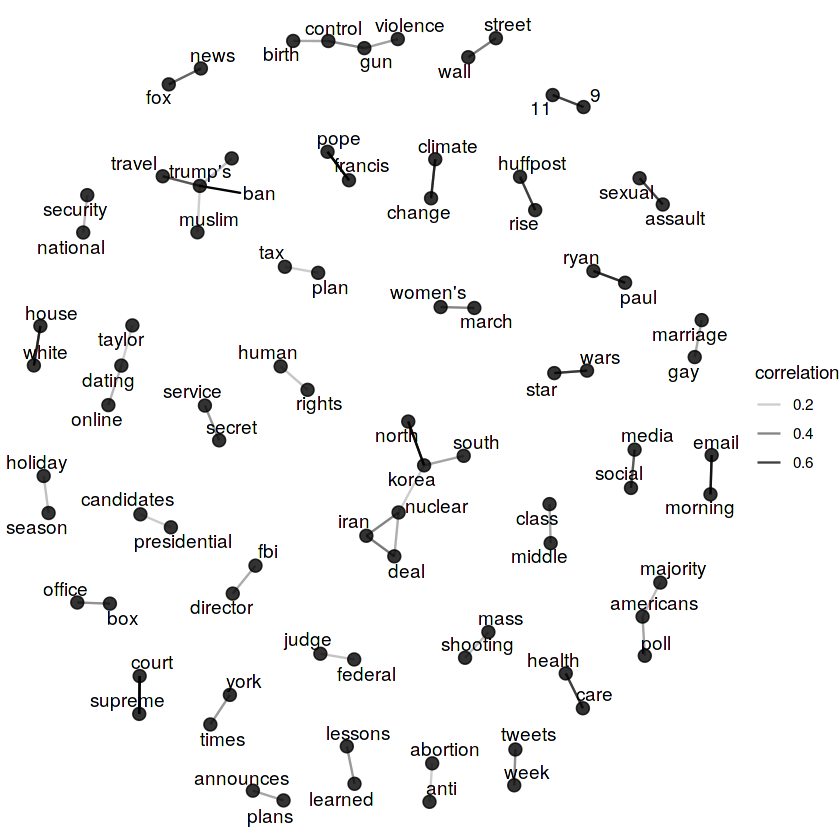

In [8]:
library(widyr)

commonNames <- c("cruz", "bernie", "clinton", "donald", "ted", "sanders", "hillary", "trump", "joe", "biden", "george", "bush")

set.seed(100)

headlineText %>% 
group_by(word) %>% 
filter(n()>50) %>% 
pairwise_cor(word, article_link, sort = TRUE) %>% 
filter(!item1 %in% commonNames & !item2 %in% commonNames) %>% 
filter(correlation>0.13) %>% 
graph_from_data_frame() %>% 
ggraph() +
geom_edge_link(aes(edge_alpha = correlation)) +
geom_node_point(size = 3, alpha = 0.8) +
geom_node_text(aes(label = name), repel = TRUE) +
theme_void()


## Text classification

Our dataset already has a classification column built-in, `is_sarcastic`. It is only natural, then, that one would attempt to train a machine learning model to predict which word is likely to be in a sarcastic headline.

As with every machine learning workflow, the first thing we do after initially processing our data is to split it into training and testing sets. I do this using the `initial_split()` function present in the `rsample` package.

In [9]:
library(rsample)

sampleDF <- sarcasmDF %>%  
initial_split()

trainDataSample <- training(sampleDF)
testDataSample <- testing(sampleDF)

I use `glimpse` to have a brief look at our training and testing sets:

In [10]:
trainDataSample %>% 
glimpse()

testDataSample %>% 
glimpse()

Observations: 20,032
Variables: 4
$ article_link <chr> "https://www.huffingtonpost.com/entry/versace-black-code…
$ headline     <chr> "former versace store clerk sues over secret 'black code…
$ is_sarcastic <int> 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,…
$ document     <int> 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20,…
Observations: 6,677
Variables: 4
$ article_link <chr> "https://www.huffingtonpost.com/entry/roseanne-revival-r…
$ headline     <chr> "the 'roseanne' revival catches up to our thorny politic…
$ is_sarcastic <int> 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,…
$ document     <int> 2, 7, 17, 18, 24, 26, 32, 33, 38, 40, 44, 45, 49, 62, 63…


Our training and testing sets have entire headlines as observations, however, we wish to use individual words as features for our machine learning model. To do this, I use a `semi_join()` on the `headlineTextData` data frame we created earlier to contain words belonging to only those `document`s that are present in our training data.

I filter out words that have a count greater than 100 for ease of processing.

In [11]:
dim(headlineText)

headlineTextData <- headlineText %>% 
add_count(word) %>% 
filter(n>100)

headlineTextData %>% 
glimpse()

trainingData <- headlineTextData %>% 
semi_join(trainDataSample, by = "document")

trainingData %>% 
glimpse()

[1] 162690      4

Observations: 27,356
Variables: 5
$ article_link <chr> "https://www.huffingtonpost.com/entry/versace-black-code…
$ is_sarcastic <int> 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,…
$ document     <int> 1, 3, 6, 8, 8, 9, 9, 10, 10, 12, 13, 13, 13, 15, 22, 22,…
$ word         <chr> "black", "mom", "women", "kids", "school", "top", "campa…
$ n            <int> 267, 198, 329, 192, 247, 126, 196, 101, 389, 112, 130, 1…
Observations: 20,650
Variables: 5
$ article_link <chr> "https://www.huffingtonpost.com/entry/versace-black-code…
$ is_sarcastic <int> 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,…
$ document     <int> 1, 3, 6, 8, 8, 9, 9, 10, 10, 12, 13, 13, 13, 15, 22, 22,…
$ word         <chr> "black", "mom", "women", "kids", "school", "top", "campa…
$ n            <int> 267, 198, 329, 192, 247, 126, 196, 101, 389, 112, 130, 1…


We need to do *binary classification* on our data, ie., we need to predict if our word belongs to a sarcastic article headline or not. To do this, I'll be creating a *logistic regression* model using the `glm()` function present in base R.

In [12]:
logModel <- glm(is_sarcastic~word-1, data = trainingData, family = "binomial")

We can use `summary()` to get an overview of our model.

In [13]:
logModel %>% 
summary()


Call:
glm(formula = is_sarcastic ~ word - 1, family = "binomial", data = trainingData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4267  -0.9897  -0.6198   1.1226   2.5596  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
word10         -1.037e+00  1.864e-01  -5.564 2.64e-08 ***
word11         -4.249e-01  2.206e-01  -1.926 0.054046 .  
word2          -4.299e-01  1.748e-01  -2.459 0.013946 *  
word20         -4.520e-01  2.162e-01  -2.090 0.036587 *  
word3          -2.839e-01  1.617e-01  -1.756 0.079173 .  
word4          -5.059e-01  1.977e-01  -2.559 0.010505 *  
word5          -1.023e+00  1.572e-01  -6.508 7.64e-11 ***
word6          -6.016e-01  1.967e-01  -3.058 0.002228 ** 
word7          -1.431e+00  2.373e-01  -6.029 1.65e-09 ***
word8          -3.567e-01  2.204e-01  -1.618 0.105579    
word9          -5.222e-01  2.134e-01  -2.448 0.014385 *  
wordamerica    -9.273e-01  1.969e-01  -4.710 2.48e-06 ***
wordamerican   -3.365e-01  1.

The `glance()` function, present in the `broom` package returns the characteristics of our model as a tibble, for manipulation within the `tidyverse`.

In [14]:
logModel %>% 
glance()

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual
28626.98,20650,-12277.76,24857.51,26055.77,24555.51,20499


We can use the `tidy()` function present in `broom` to get a look at the estimates associated with the coefficients of our model, after which we can visualize the most significant predictors in the following manner:

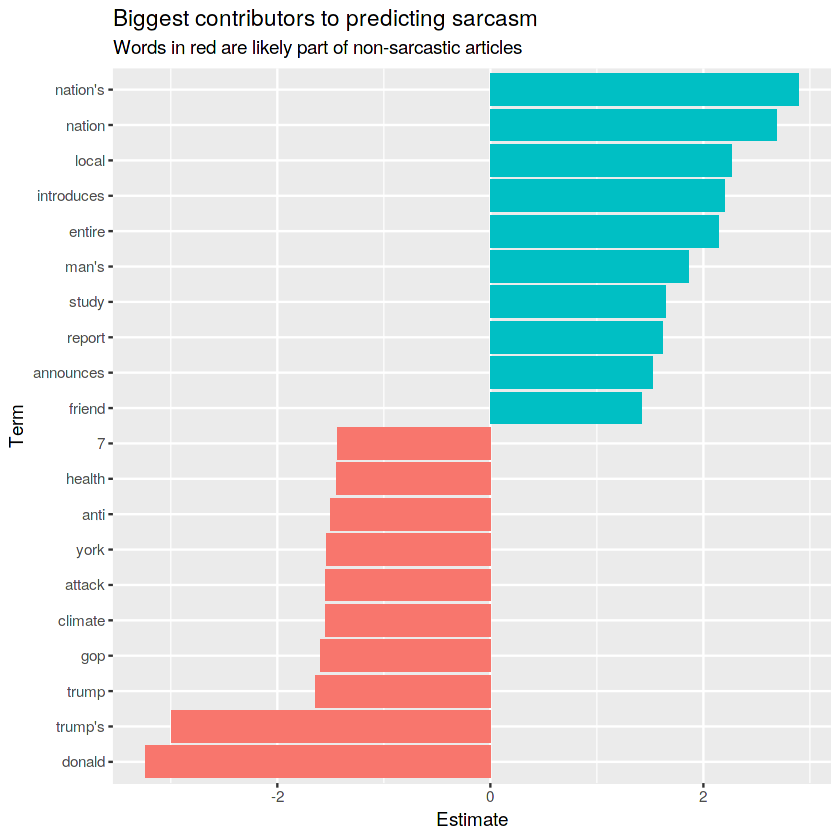

In [15]:
logModel %>% 
tidy() %>% 
group_by(estimate>0) %>% 
top_n(10, abs(estimate)) %>% 
ungroup() %>% 
mutate(term = str_remove(term, "word")) %>% 
ggplot(aes(fct_reorder(term, estimate), estimate, fill = estimate > 0)) +
geom_col(aes(fill = estimate>0)) +
coord_flip() +
labs(title = "Biggest contributors to predicting sarcasm", subtitle = "Words in red are likely part of non-sarcastic articles", x = "Term",y = "Estimate") +
guides(fill = FALSE)

For evaluating the performance of our model, we first need to ensure that our test data is of the same format as our training data, after which I use the `predict` function to generate the predictions of our model on our test data.

I visualize the confusion matrix as follows:

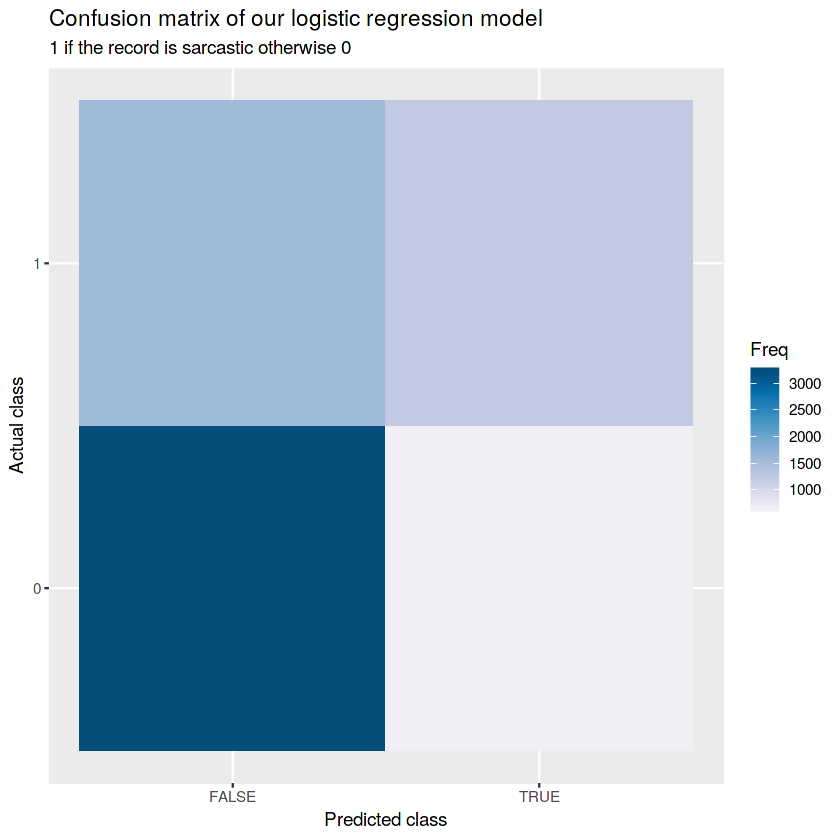

In [16]:
testingData <- headlineTextData %>% 
semi_join(testDataSample, by = "document")

predictions <- predict(logModel, newdata = testingData, type = "response")

table(predictions>0.5, testingData$is_sarcastic) %>% 
as.data.frame() %>% 
ggplot(aes(Var1, Var2)) +
geom_tile(aes(fill = Freq)) +
scale_fill_distiller(direction = 1, palette = 9) +
labs(title = "Confusion matrix of our logistic regression model", x = "Predicted class", y = "Actual class", subtitle = "1 if the record is sarcastic otherwise 0")

Another method for evaluating model performance is through the use of  *ROC (Receiver Operating Characteristic)* curves. The ROC is a comparison of two operating characteristics (True Positive Rate and False Positive Rate) at various thresholds.

* *TPR = Sensitivity*
* *FPR = 1-Specificity*

The diagonal line directly corresponds to a straight line having the equation *y=x*, which represents the performance of our model if we had done random guessing. A curve below this line implies that the model performed even worse than a baseline of random guessing, whereas a curve above the line shows better performance.

In other words, the higher the curve, the better the performance.

For binary classification, the first factor level is assumed to be the event.
Set the global option `yardstick.event_first` to `FALSE` to change this.


Attaching package: ‘yardstick’

The following object is masked from ‘package:readr’:

    spec



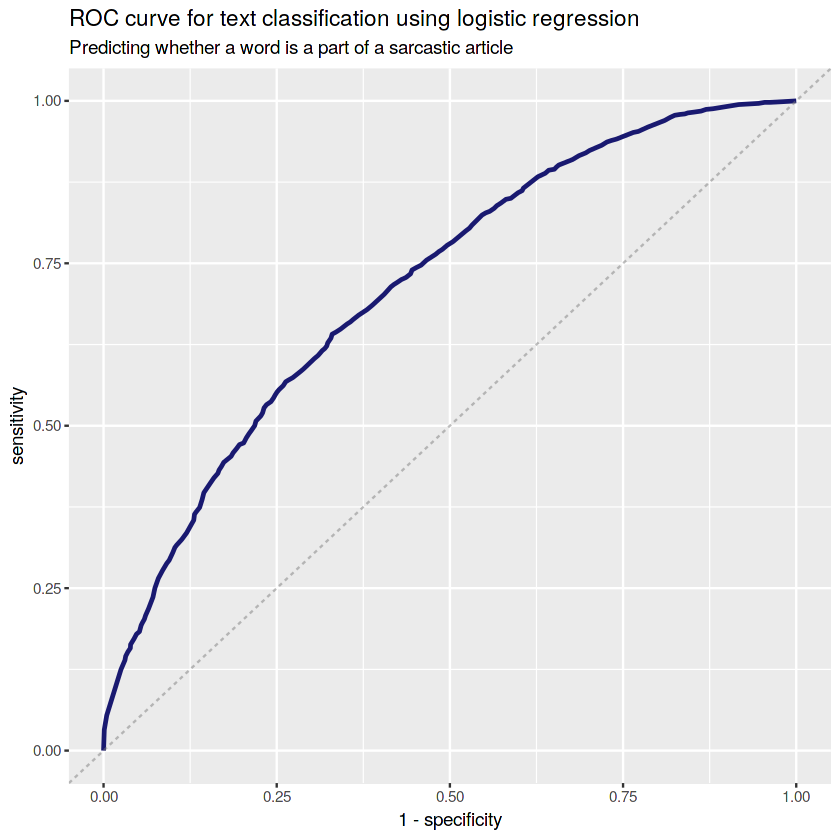

In [17]:
library(yardstick)

testingData %>% 
cbind(probability = predictions) %>% 
mutate(is_sarcastic = as.factor(is_sarcastic)) %>% 
roc_curve(is_sarcastic, probability) %>% 
ggplot(aes(x = 1 - specificity, y = sensitivity)) +
geom_line(color = "midnightblue", size = 1) +
geom_abline(lty = 2, alpha = 0.5, color = "gray50") +
labs(title = "ROC curve for text classification using logistic regression", subtitle = "Predicting whether a word is a part of a sarcastic article")


As we can see from above, our model does not perform the greatest on our test data. This could be due to a variety of factors, one of them being the *lack of context* in our data, which is essential to deciding whether a piece of text is sarcastic or not. 

Another factor could be simply due to our choice of model. Regression models, while simple and very interpretable, fall short if we are dealing with data that has a lot of outliers, or data that has no discernible pattern. This might be the case with our sarcasm dataset.

I could have used more complex models like *classification trees* or even *random forests*, which, while good at dealing with complicated patterns,  are not fully supported under `broom` yet, which makes analyzing them within the `tidyverse` tough.

## Conclusion

Some key takeaways that we can take from the data:

* The data shows a heavy bias towards America-focused content, as evident with the frequency of names like *Clinton*, *Trump*, and *GOP*.
* Expletives are a lot more specific in sarcastic article headlines.
* Logistic regression is not necessarily the best option for the data here.
* Looking at words as co-related pairs leads to a lot more insights rather than just inspecting them as bigrams.
* Text analysis is fascinating.
